In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import pickle
import datetime
import os
import seaborn as sns
from sklearn.preprocessing import *

%matplotlib inline


from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

In [5]:
xtrain=pd.read_csv('Airbnb_xtrain_jim.csv',index_col=0)
ytrain=pd.read_csv('Airbnb_ytrain_jim.csv',header=None)

In [7]:
xtrain.head()

,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_283,c_284,c_285,c_286,c_287,c_288,c_289,c_290,c_291,all_null
0,2009,3,19,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,292
1,2009,5,23,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,292
2,2009,6,9,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,292
3,2009,10,31,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,292
4,2009,12,8,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,292


In [41]:
ytrain.shape

(213451, 1)

### 1. 目标变量进行labels encoding

In [43]:
le=LabelEncoder()
ytrain_le=le.fit_transform(ytrain.values)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
ytrain_le

array([ 7,  7, 10, ...,  7,  7,  7], dtype=int64)

### 2.提取10%数据进行训练

In [46]:
n=int(xtrain.shape[0]*0.1)
xtrain_new=xtrain.iloc[:n,:]
ytrain_new=ytrain_le[:n]

### 3. 标准化训练集

In [47]:
x_scaler=StandardScaler()
xtrain_new=x_scaler.fit_transform(xtrain_new)

### 4. 评分模型：NDCG

In [48]:
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    
    """
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    
    #order = [3,2,1,7]
    #y_true = [0,1,0,0]
    #y_true =[0,0,1,0]
    
    

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)
    # 0 doesn't count =>>>> only reduce 1 


def ndcg_score(ground_truth, predictions, k=5):
    
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.
        
    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    
    #ground_truth = [1, 0, 2]  =>>>> 
    #ground_truth : [[0, 1, 0],       [1, 0, 0],    [0, 0, 1]]
    #predictions: [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    #zip =>>> take one vector from each batch

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

### 5. 逻辑回归

In [49]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression( penalty='l2',multi_class='ovr')
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
from sklearn.model_selection import KFold,cross_val_score,train_test_split

In [51]:
RANDOM_STATE=2018

kf=KFold(n_splits=5,random_state=2018)

In [52]:
train_score=[]
cv_score=[]

In [92]:
k_ndcg=3
for train_index,test_index in kf.split(xtrain_new,ytrain_new):
    X_train,X_test=xtrain_new[train_index,:],xtrain_new[test_index,:]
    y_train,y_test=ytrain_new[train_index],ytrain_new[test_index]
    
    print (X_train.shape, X_test.shape)
    
    lr.fit(X_train,y_train)
    
    y_pred=lr.predict_proba(X_test)
    score=lr.score(X_test,y_test)
    print(score)
    
    train_ndcg_score=ndcg_score(y_train,lr.predict_proba(X_train),k=k_ndcg)
    cv_ndcg_score=ndcg_score(y_test,y_pred,k=k_ndcg)
    
    train_score.append(train_ndcg_score)
    cv_score.append(cv_ndcg_score)
    
print ("\nThe training score is: {}".format(np.mean(train_score)))
print ("\nThe cv score is: {}".format(np.mean(cv_score))) 

(14230, 496) (7115, 496)
0.4753338018271258
(14230, 496) (7115, 496)
0.5558678847505271
(14230, 496) (7115, 496)
0.5338018271257906

The training score is: 0.7694343174405311

The cv score is: 0.6468492651862073


> 5.1 改变迭代次数 iteration

In [82]:
iteration = [1,5,10,15,20, 50, 100]
kf = KFold(n_splits=3, random_state=RANDOM_STATE)

train_score = []
cv_score = []
k_ndcg = 5

for i,v in enumerate(iteration):
    print ('{} iterations:'.format(v))
    lr=LogisticRegression(max_iter=v,tol=1e-5,solver='newton-cg')
    print (lr)
    train_score_iter = []
    cv_score_iter = []
    
    for train_index, test_index in kf.split(xtrain_new,ytrain_new):
        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]
        
        lr.fit(X_train,y_train)
        
        y_pred=lr.predict_proba(X_test)
        train_ndcg_score = ndcg_score(y_train, lr.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)


    train_score_iter.append(train_ndcg_score)
    cv_score_iter.append(cv_ndcg_score)
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))
    print ("\nThe training score is: {}".format(np.mean(train_score_iter)))
    print ("The cv score is: {}\n".format(np.mean(cv_score_iter)))

1 iterations:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=1e-05,
          verbose=0, warm_start=False)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the


The training score is: 0.7277262706225184
The cv score is: 0.08541502741106331

5 iterations:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=1e-05,
          verbose=0, warm_start=False)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the


The training score is: 0.7792875783813167
The cv score is: 0.35264039229275257

10 iterations:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=1e-05,
          verbose=0, warm_start=False)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the


The training score is: 0.7813353603180998
The cv score is: 0.7431825096520476

15 iterations:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=15, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=1e-05,
          verbose=0, warm_start=False)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the


The training score is: 0.7813197478983283
The cv score is: 0.7657155850942708

20 iterations:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=20, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=1e-05,
          verbose=0, warm_start=False)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the


The training score is: 0.781322827571613
The cv score is: 0.7660178328793978

50 iterations:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=1e-05,
          verbose=0, warm_start=False)

The training score is: 0.781322827571613
The cv score is: 0.7660178328793978

100 iterations:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=1e-05,
          verbose=0, warm_start=False)

The training score is: 0.781322827571613
The cv score is: 0.7660178328793978



In [84]:
train_score

[0.7277262706225184,
 0.7792875783813167,
 0.7813353603180998,
 0.7813197478983283,
 0.781322827571613,
 0.781322827571613,
 0.781322827571613]

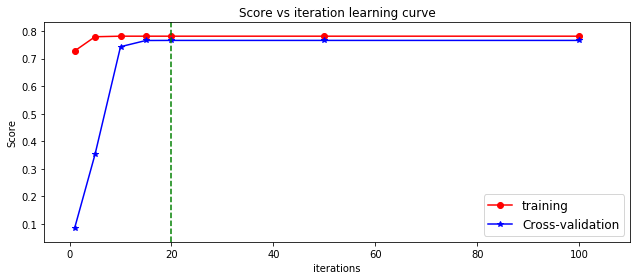

In [87]:
ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

plt.figure(figsize=(9,4))
plt.plot(iteration, train_score, 'ro-', label = 'training')
plt.plot(iteration, cv_score, 'b*-', label = 'Cross-validation')
plt.xlabel("iterations")
plt.ylabel("Score")
plt.xlim(-5, np.max(iteration)+10)
plt.ylim(ymin, ymax)
plt.plot(np.linspace(20,20,50), np.linspace(ymin, ymax, 50), 'g--')
plt.legend(loc = 'lower right', fontsize = 12)
plt.title("Score vs iteration learning curve")

plt.tight_layout()


## 6. 采用树模型

In [94]:
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import*
from sklearn.svm import SVC,LinearSVC,NuSVC

LEARNING_RATE = 0.1
N_ESTIMATORS = 50
RANDOM_STATE = 2018
MAX_DEPTH = 9
clf_tree ={
    'DTree': DecisionTreeClassifier(max_depth=MAX_DEPTH,
                                    random_state=RANDOM_STATE),
    
    'RF': RandomForestClassifier(n_estimators=N_ESTIMATORS,
                                 max_depth=MAX_DEPTH,
                                 random_state=RANDOM_STATE),
    
    'AdaBoost': AdaBoostClassifier(n_estimators=N_ESTIMATORS,
                                   learning_rate=LEARNING_RATE,
                                   random_state=RANDOM_STATE),
    
    'Bagging': BaggingClassifier(n_estimators=N_ESTIMATORS,
                                 random_state=RANDOM_STATE),
    
    'ExtraTree': ExtraTreesClassifier(max_depth=MAX_DEPTH,
                                      n_estimators=N_ESTIMATORS,
                                      random_state=RANDOM_STATE),
    
    'GraBoost': GradientBoostingClassifier(learning_rate=LEARNING_RATE,
                                           max_depth=MAX_DEPTH,
                                           n_estimators=N_ESTIMATORS,
                                           random_state=RANDOM_STATE)
}

In [95]:
for key in clf_tree.keys():
    print(clf_tree[key])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2018,
            splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=2018)
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, m

In [96]:
train_score = []
cv_score = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_tree.keys():
    
    clf = clf_tree[key]
    print (clf)
    
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

        print (X_train.shape, X_test.shape)
        
        clf.fit(X_train, y_train)

        y_pred = clf.predict_proba(X_test)

        # for binary classification: we used to use f1 score, precision, recall, auc score.
        # here for Airbnb we use the ndcg evaluation. 

        train_ndcg_score = ndcg_score(y_train, clf.predict_proba(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score.append(np.mean(train_score_iter))
    cv_score.append(np.mean(cv_score_iter))
    
    print ("\nThe training score is: {}".format(np.mean(train_score_iter)))
    print ("The cv score is: {}\n".format(np.mean(cv_score_iter)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2018,
            splitter='best')
(14230, 496) (7115, 496)
(14230, 496) (7115, 496)
(14230, 496) (7115, 496)

The training score is: 0.8033561363903812
The cv score is: 0.7537795524509022

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)
(14230, 496) (7115, 496)
(14230, 496) (7115, 496)
(14230, 496) (7115, 496)

The 

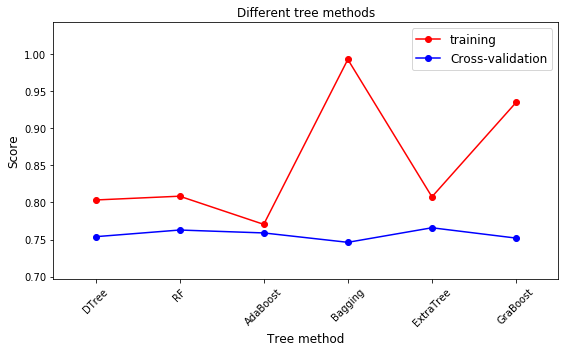

In [98]:
ymin = np.min(cv_score)-0.05
ymax = np.max(train_score)+0.05

x_ticks = clf_tree.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 5.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different tree methods")

plt.tight_layout()

## 7. SVM模型

In [106]:
Tol=1e-4
Max_iter=1000

clf_svm={
    
    'SVM-rbf':SVC(kernel='rbf',decision_function_shape='ovr',
                  max_iter=Max_iter,tol=Tol,
                  random_state=RANDOM_STATE),
          
    'SVM-poly': SVC(kernel='poly',
                   max_iter=Max_iter,
                   tol=Tol, random_state=RANDOM_STATE,
                   decision_function_shape='ovr'),      # 多项式
    
    'SVM-linear': SVC(kernel='linear',
                      max_iter=Max_iter,
                      tol=Tol, 
                      random_state=RANDOM_STATE,
                      decision_function_shape='ovr')# 线性核
    
}


In [107]:
for i in clf_svm:
    print(clf_svm[i])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=False, random_state=2018, shrinking=True,
  tol=0.0001, verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=1000, probability=False, random_state=2018, shrinking=True,
  tol=0.0001, verbose=False)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=2018, shrinking=True,
  tol=0.0001, verbose=False)


In [108]:
train_score_svm = []
cv_score_svm = []

kf = KFold(n_splits=3, random_state=RANDOM_STATE)

k_ndcg = 5

for key in clf_svm.keys():
    
    clf = clf_svm.get(key)
    print (clf)
    
    train_score_iter = []
    cv_score_iter = []

    for train_index, test_index in kf.split(xtrain_new, ytrain_new):

        X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
        y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

        print (X_train.shape, X_test.shape)
        
        clf.fit(X_train, y_train)

        y_pred = clf.decision_function(X_test)

        # for binary classification: we used to use f1 score, precision, recall, auc score.
        # here for Airbnb we use the ndcg evaluation. 

        train_ndcg_score = ndcg_score(y_train, clf.decision_function(X_train), k = k_ndcg)
        cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

        train_score_iter.append(train_ndcg_score)
        cv_score_iter.append(cv_ndcg_score)
        
    train_score_svm.append(np.mean(train_score_iter))
    cv_score_svm.append(np.mean(cv_score_iter))
    
    print ("\nThe training score is: {}".format(np.mean(train_score_iter)))
    print ("The cv score is: {}\n".format(np.mean(cv_score_iter)))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=False, random_state=2018, shrinking=True,
  tol=0.0001, verbose=False)
(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



The training score is: 0.7322043044343273
The cv score is: 0.7305278886129575

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=1000, probability=False, random_state=2018, shrinking=True,
  tol=0.0001, verbose=False)
(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



The training score is: 0.7213834177132151
The cv score is: 0.7157406838658097

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=1000, probability=False, random_state=2018, shrinking=True,
  tol=0.0001, verbose=False)
(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


(14230, 496) (7115, 496)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



The training score is: 0.6657449135491533
The cv score is: 0.6202387606444676



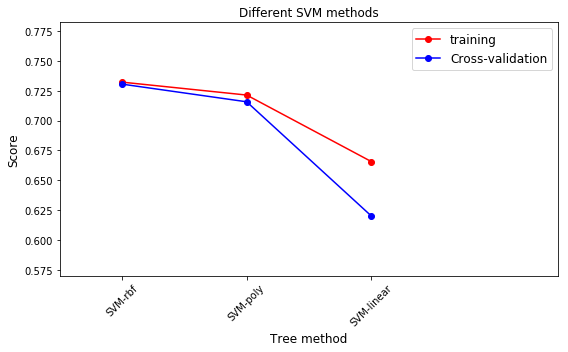

In [109]:
ymin = np.min(cv_score_svm)-0.05
ymax = np.max(train_score_svm)+0.05

x_ticks = clf_svm.keys()

plt.figure(figsize=(8,5))
plt.plot(range(len(x_ticks)), train_score_svm, 'ro-', label = 'training')
plt.plot(range(len(x_ticks)),cv_score_svm, 'bo-', label = 'Cross-validation')

plt.xticks(range(len(x_ticks)),x_ticks,rotation = 45, fontsize = 10)
plt.xlabel("Tree method", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.xlim(-0.5, 3.5)
plt.ylim(ymin, ymax)

plt.legend(loc = 'best', fontsize = 12)
plt.title("Different SVM methods")

plt.tight_layout()

## 8. 采用Xgboost

In [115]:
import xgboost as xgb

In [116]:
def customized_eval(preds, dtrain):
    labels = dtrain.get_label()
    top = []
    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])
    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score

In [118]:
# xgboost parameters

NUM_XGB = 200

params = {}
params['colsample_bytree'] = 0.6
params['max_depth'] = 6
params['subsample'] = 0.8
params['eta'] = 0.3
params['seed'] = RANDOM_STATE
params['num_class'] = 12
params['objective'] = 'multi:softprob'   # output the probability instead of class. 

print (params)

{'colsample_bytree': 0.6, 'max_depth': 6, 'subsample': 0.8, 'eta': 0.3, 'seed': 2018, 'num_class': 12, 'objective': 'multi:softprob'}


In [119]:
train_score_iter = []
cv_score_iter = []

kf = KFold(n_splits = 3, random_state=RANDOM_STATE)

k_ndcg = 5


for train_index, test_index in kf.split(xtrain_new, ytrain_new):

    X_train, X_test = xtrain_new[train_index, :], xtrain_new[test_index, :]
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

    print (X_train.shape, X_test.shape)
    
    train_xgb = xgb.DMatrix(X_train, label= y_train)
    test_xgb = xgb.DMatrix(X_test, label = y_test)
    
    watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]

    bst = xgb.train(params, 
                     train_xgb,
                     NUM_XGB,
                     watchlist,
                     feval = customized_eval,
                     verbose_eval = 3,
                     early_stopping_rounds = 5)
    
    
    #bst = xgb.train( params, dtrain, num_round, evallist )

    y_pred = np.array(bst.predict(test_xgb))
    y_pred_train = np.array(bst.predict(train_xgb))
    
    # for binary classification: we used to use f1 score, precision, recall, auc score.
    # here for Airbnb we use the ndcg evaluation. 

    train_ndcg_score = ndcg_score(y_train, y_pred_train , k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

    train_score_iter.append(train_ndcg_score)
    cv_score_iter.append(cv_ndcg_score)

train_score_xgb = np.mean(train_score_iter)
cv_score_xgb = np.mean(cv_score_iter)

print ("\nThe training score is: {}".format(train_score_xgb))
print ("The cv score is: {}\n".format(cv_score_xgb))

(14230, 496) (7115, 496)
[0]	train-merror:0.440267	test-merror:0.520309	train-ndcg5:0.790577	test-ndcg5:0.741909
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.417077	test-merror:0.499227	train-ndcg5:0.804286	test-ndcg5:0.752044
Stopping. Best iteration:
[0]	train-merror:0.440267	test-merror:0.520309	train-ndcg5:0.790577	test-ndcg5:0.741909

(14230, 496) (7115, 496)
[0]	train-merror:0.471398	test-merror:0.505973	train-ndcg5:0.772553	test-ndcg5:0.762973
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.431413	test-merror:0.455798	train-ndcg5:0.794112	test-ndcg5:0.781781
Stopping. Best iteration:
[0]	train-merror:0.471398	test-merror:0.505973	train-ndcg5:0.772553	test-ndcg5:0.762973

(14230, 496) (7115, 496)
[0]	train-merror:0.461771	test-merror:0.525088	train-nd